# Master Experiment Notebook

This notebook contains the basic structure of a test. We set up some data from our datasets, implement a simple ngmix measurement from that, and compare to  autodiff and finitediff from autometacal.

Data can have:

- some coherent shear applied to all galaxies
- some level of noise applied to them

The goal is to get (at least some of) the following experiments running:

1. How the performance compares? If we do 100 blocks of 1000 galaxies, how long does it take for autometacal, vs ngmix?
2. Can AutoMetaCal perform better than ngmix by using the input PSFs for reconv? Using the PSF response...
3. How does Autodiff vs Finitediff vs ngmix compare with realistic galaxies?
4. How does Autodiff vs ngmix go with model fitting?
5. Can we add less noise in the metacal procedure?

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import tqdm

import autometacal as amc
import tensorflow_datasets as tfds
import tensorflow as tf
import galflow as gf
import ngmix

/local/home/az264973/.local/lib/python3.8/site-packages/jax/__init__.py:27: UserWarning: cloud_tpu_init failed: ConnectionError(MaxRetryError("HTTPConnectionPool(host='metadata.google.internal', port=80): Max retries exceeded with url: /computeMetadata/v1/instance/attributes/agent-worker-number (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fa94e4ba550>: Failed to establish a new connection: [Errno -2] Name or service not known'))"))
 This a JAX bug; please report an issue at https://github.com/google/jax/issues
  _warn(f"cloud_tpu_init failed: {repr(exc)}\n This a JAX bug; please report "
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### Test setup

In [3]:
#global values
fixnoise = True
batch_size=1000
scale= .2
stamp_size = 51
rng = np.random.RandomState(31415)
real_shear = [0.01,0.0]
noise_level = 5e-3

### Data

In [4]:
#dataset
data= tfds.load('GalGen/small_stamp_100k')
data = data['train'].cache()
data = data.shuffle(batch_size)
data = data.batch(batch_size)
data = data.prefetch(tf.data.experimental.AUTOTUNE)

Display a range of galaxy models:

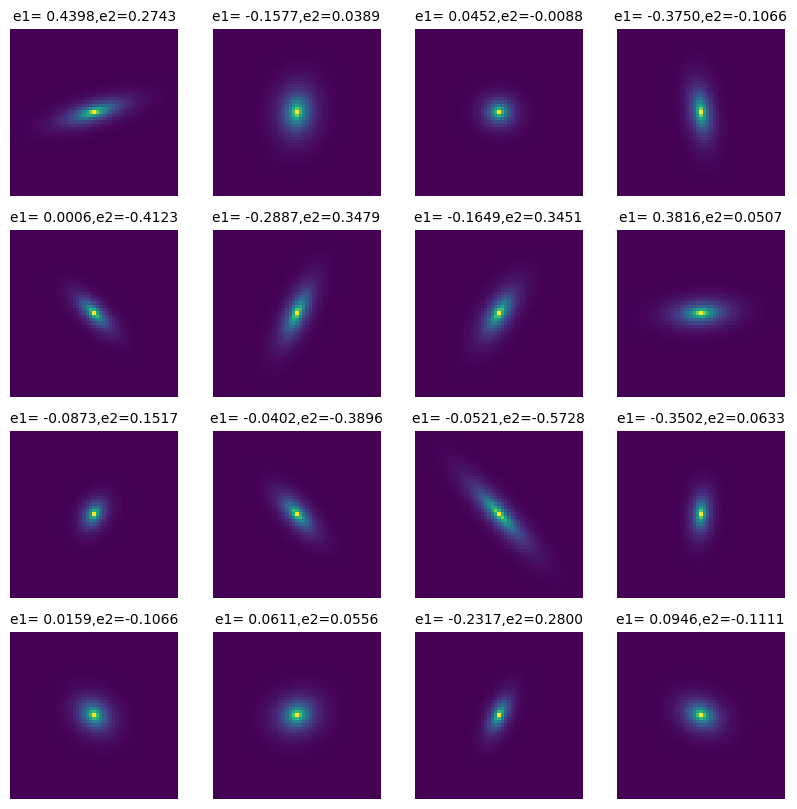

In [5]:
batchit = data.as_numpy_iterator()
onebatch = batchit.next()
gal_images = onebatch['gal_model'] 
labels = onebatch['label'] 
style.use('default')
figure(figsize=(10,10))
for i in range(16):
  subplot(4,4,i+1)
  imshow(gal_images[i],origin='lower')
  title(f"e1= {labels[i][0]:.4f},e2={labels[i][1]:.4f}",fontsize=10)
  axis('off')

We transform these models by:
1. Adding a constant shear
3. Convolving with a PSF
2. Adding some noise

Both 1 and 2 are taken care by the noiseless_real_mcal_image function developed for the LearnR project.

In [6]:
#create 1 batch of observed images
gal_images=amc.noiseless_real_mcal_image(onebatch['gal_model'],
                                         onebatch['psf_image'],
                                         tf.repeat([real_shear],
                                        len(onebatch['gal_model']),axis=0))

noise = np.random.normal(scale=noise_level,size=[batch_size,51,51])
gal_images += noise
psf_images = onebatch['psf_image']

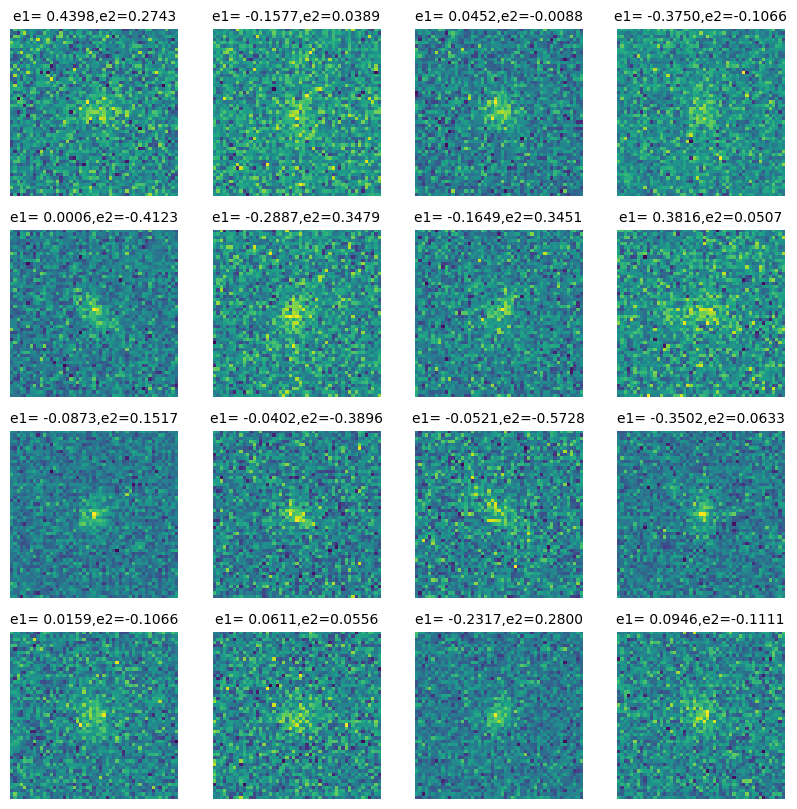

In [7]:
batchit = data.as_numpy_iterator()
onebatch = batchit.next()
style.use('default')
figure(figsize=(10,10))
for i in range(16):
  subplot(4,4,i+1)
  imshow(gal_images[i],origin= 'lower')
  title(f"e1= {labels[i][0]:.4f},e2={labels[i][1]:.4f}",fontsize=10)
  axis('off')

## Set up ngmix

In [8]:
#set up jacobian
jacobian = ngmix.DiagonalJacobian(
  row=stamp_size//2, 
  col=stamp_size//2,
  scale=scale,
)
psf_jacobian = ngmix.DiagonalJacobian(
  row=stamp_size//2, 
  col=stamp_size//2,
  scale=scale,
)

In [9]:
# We will measure moments with a fixed gaussian weight function
weight_fwhm = 1.2
fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)
psf_fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)

# these "runners" run the measurement code on observations
psf_runner = ngmix.runners.PSFRunner(fitter=psf_fitter)
runner = ngmix.runners.Runner(fitter=fitter)

# this "bootstrapper" runs the metacal image shearing as well as both 
# psf and object measurements

types = ['noshear', '1p', '1m','2p','2m']
boot = ngmix.metacal.MetacalBootstrapper(
  runner=runner, psf_runner=psf_runner,
  rng=rng,
  psf='gauss',
  types=types,
  fixnoise=fixnoise,
)

Set up functions to get responses from AMC and ngmix

In [10]:
#for ngmix
def get_metacal_response_ngmix(resdict):
  step=0.01

  e1, e2 = resdict['noshear']['e1'], resdict['noshear']['e2']
 
  g0s = np.array([resdict['noshear']['e1'], resdict['noshear']['e2']])
  g1p = np.array([resdict['1p']['e1'], resdict['1p']['e2']])
  g1m = np.array([resdict['1m']['e1'], resdict['1m']['e2']])
  g2p = np.array([resdict['2p']['e1'], resdict['2p']['e2']])
  g2m = np.array([resdict['2m']['e1'], resdict['2m']['e2']])    
  
  R11 = (g1p[0]-g1m[0])/(2*step)
  R21 = (g1p[1]-g1m[1])/(2*step) 
  R12 = (g2p[0]-g2m[0])/(2*step)
  R22 = (g2p[1]-g2m[1])/(2*step)  
   
  ellip_dict = {
    'noshear':g0s,
    '1p':g1p,
    '1m':g1m,
    '2p':g2p,
    '2m':g2m,    
  } 
  
  R = np.array(
    [[R11,R12],
     [R21,R22]])
    
  return ellip_dict, R 

#AutoMetaCal runner
method = lambda im: amc.get_moment_ellipticities(im, scale=0.2, fwhm=1.2)

#for amc
@tf.function
def response(gal_images,psf_images):
  return amc.get_metacal_response(gal_images, psf_images,psf_images,method)

## Shakedown Test!

Let's make a measurement on a single image.

In [11]:
im = gal_images[0]
psf_im = psf_images[0] 

In [12]:
wt = tf.reduce_mean(1.0/(noise)**2,axis=0)
psf_wt = tf.reduce_mean(1.0/(noise/100)**2,axis=0)

psf_obs = ngmix.Observation(
  psf_im,
  weight=psf_wt,
  jacobian=psf_jacobian,
)
obs = ngmix.Observation(
  im,
  jacobian=jacobian,
  weight=wt,
  psf=psf_obs,
)

Run one ngmix measurement:

In [13]:
resdict, obsdict = boot.go(obs)

In [14]:
true = labels[0]

#ngmix calibration
ellips, R_ngmix = get_metacal_response_ngmix(resdict)
calibrated_ngmix = linalg.inv(R_ngmix) @ ellips['noshear']

e_amc, R_auto = response(im[tf.newaxis], psf_im[tf.newaxis])
calibrated_amc = linalg.inv(R_auto[0].numpy()) @ e_amc[0].numpy()

In [15]:
print("True:")
print(f"e1={true[0]:.6f}, e2={true[1]:.6f}.")

print("\nngmix:")
print(f"e1={calibrated_ngmix[0]:.6f}, e2={calibrated_ngmix[1]:.6f}.")

print("\nAutoMetaCal")
print(f"e1={calibrated_amc[0]:.6f}, e2={calibrated_amc[1]:.6f}.")

True:
e1=0.439777, e2=0.274259.

ngmix:
e1=0.458393, e2=-0.023440.

AutoMetaCal
e1=0.428331, e2=-0.016302.


Different Reconvolution PSFs if needed

## One Batch Test

In [16]:
#reset data
batchit = data.as_numpy_iterator()
onebatch = batchit.next()

In [17]:
#get response and noshear ellipticities
e_amc, R_auto = response(gal_images, psf_images)
e_amc=tf.concat([e_amc],axis=0)
R_auto=tf.concat([R_auto],axis=0)

#averaging procedure
uncalibrated_shear_amc = tf.reduce_mean(e_amc,axis=0)
calibrated_shear_amc = tf.linalg.inv(tf.reduce_mean(R_auto[:],axis=0)) @ tf.reduce_mean(tf.reshape(e_amc,[-1,2,1]),axis=0)
calibrated_shear_amc_err = tf.linalg.inv(tf.reduce_mean(R_auto[:],axis=0)) @ tf.math.reduce_std(tf.reshape(e_amc,[-1,2,1]),axis=0)/sqrt(batch_size)

Testing AMC speed: 

In [18]:
%%timeit
e_amc_batch, R_auto_batch = response(gal_images, psf_images)

4.98 s ± 18.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


To be fair, let's use ngmix in parallel. 

In [19]:
#parallelisable function to map the data to
def response_ngmix(im_psf):
  im, psf = im_psf
  
  psf_obs = ngmix.Observation(
    psf_im,
    weight=psf_wt,
    jacobian=psf_jacobian,
  )
  obs = ngmix.Observation(
    im,
    jacobian=jacobian,
    weight=wt,
    psf=psf_obs,
  )
  
  #get moment ellipticities
  resdict, obsdict = boot.go(obs)
  e_ngmix, R_ngmix = get_metacal_response_ngmix(resdict)
  
  return e_ngmix['noshear'], R_ngmix

In [20]:
from multiprocessing import Pool, freeze_support, cpu_count
pool = Pool(cpu_count()) 

In [21]:
gal_imlist = [gal_images.numpy()[i] for i in range(len(gal_images))]
psf_imlist = [psf_images[i] for i in range(len(gal_images))]
ims_psfs = zip(gal_imlist,psf_imlist)

Testing ngmix speed:

In [22]:
t = time.time()
results = pool.map(response_ngmix, ims_psfs)
print(f"Finished in: {time.time()-t} s.")

Finished in: 4.9933295249938965 s.


In [23]:
pool.close()

In [24]:
e_ngmix_list = [result[0] for result in results]
R_ngmix_list = [result[1] for result in results]

In [25]:
calibrated_shear_ngmix = linalg.inv(mean(array(R_ngmix_list),axis=0)) @ mean(array(e_ngmix_list),axis=0)
calibrated_shear_ngmix_err = linalg.inv(mean(array(R_ngmix_list),axis=0)) @ std(array(e_ngmix_list),axis=0)/sqrt(batch_size)

In [26]:
print("True:")
print(f"e1={real_shear[0]:.6f}, e2={real_shear[1]:.6f}.")

print("\nUncalibrated shear estimation over 1k")
print(f"e1={uncalibrated_shear_amc[0]:.6f}, e2={uncalibrated_shear_amc[1]:.6f}.")

print("\nAutoMetaCal shear estimation over 1k")
print(f"e1={calibrated_shear_amc[0,0]:.6f}, e2={calibrated_shear_amc[1,0]:.6f}.")

print("\nngmix shear estimation over 1k")
print(f"e1={calibrated_shear_ngmix[0]:.6f}, e2={calibrated_shear_ngmix[1]:.6f}.")

True:
e1=0.010000, e2=0.000000.

Uncalibrated shear estimation over 1k
e1=0.004567, e2=0.000175.

AutoMetaCal shear estimation over 1k
e1=0.010337, e2=0.000309.

ngmix shear estimation over 1k
e1=0.009975, e2=-0.000213.


In [27]:
m1_amc =  calibrated_shear_amc[0,0]/real_shear[0] - 1 
m1_amc_err =  calibrated_shear_amc_err[0,0]/real_shear[0]
print("Autometacal:")
print(f"m_1 = {m1_amc: .6f} +/- {m1_amc_err: .6f}")

m1_ngmix =  calibrated_shear_ngmix[0]/real_shear[0] -1 
m1_ngmix_err =  calibrated_shear_ngmix_err[0]/real_shear[0] 
print("\nngmix:")
print(f"m_1 = {m1_ngmix: .6f} +/- {m1_ngmix_err: .6f}")

Autometacal:
m_1 =  0.033687 +/-  0.918352

ngmix:
m_1 = -0.002545 +/-  0.924223


## All Batches Test

In [28]:
#reset data
batchit = data.as_numpy_iterator()

In [29]:
e_amc = []
R_auto = []
e_ngmix_list = []
R_ngmix_list = []

for _ in tqdm.tqdm(range(100)):
  onebatch = batchit.next()
  
  #prepare batch
  gal_images=amc.noiseless_real_mcal_image(onebatch['gal_model'],onebatch['psf_image'],
                            tf.repeat([real_shear],len(onebatch['gal_model']),axis=0))

  noise = np.random.normal(scale=noise_level,size=[len(gal_images),51,51])
  
  gal_images += noise
  psf_images = onebatch['psf_image']

  #run amc
  e_amc_batch, R_auto_batch = response(gal_images, psf_images)
  #gather amc results
  e_amc.append(e_amc_batch)
  R_auto.append(R_auto_batch)
  
  #prepare list for parallel map
  gal_imlist = [gal_images.numpy()[i] for i in range(len(gal_images))]
  psf_imlist = [psf_images[i] for i in range(len(gal_images))]
  ims_psfs = zip(gal_imlist,psf_imlist)
  
  #start and run parallel pool
  pool = Pool(cpu_count()//2)
  results = pool.map(response_ngmix, ims_psfs)
  pool.close()
  
  #append ngmix results
  e_ngmix_list += [result[0] for result in results]
  R_ngmix_list += [result[1] for result in results]  
  
e_amc=tf.concat(e_amc,axis=0)
R_auto=tf.concat(R_auto,axis=0)

100%|██████████| 100/100 [29:52<00:00, 17.93s/it]


In [30]:
#averaging amc results
uncalibrated_shear_amc = tf.reduce_mean(e_amc,axis=0)
calibrated_shear_amc = tf.linalg.inv(tf.reduce_mean(R_auto[:],axis=0)) @ tf.reduce_mean(tf.reshape(e_amc,[-1,2,1]),axis=0)
calibrated_shear_amc_err = tf.linalg.inv(tf.reduce_mean(R_auto[:],axis=0)) @ tf.math.reduce_std(tf.reshape(e_amc,[-1,2,1]),axis=0)/sqrt(batch_size*100)

#averaging ngmix results
calibrated_shear_ngmix = linalg.inv(mean(array(R_ngmix_list),axis=0)) @ mean(array(e_ngmix_list),axis=0)
calibrated_shear_ngmix_err = linalg.inv(mean(array(R_ngmix_list),axis=0)) @ std(array(e_ngmix_list),axis=0)/sqrt(batch_size*100)

In [31]:
m1_amc =  calibrated_shear_amc[0,0]/real_shear[0] -1 
m1_amc_err = calibrated_shear_amc_err[0,0]/real_shear[0]

print("Autometacal:")
print(f"m_1 = {m1_amc: .6f} +/- {m1_amc_err: .6f}")

m1_ngmix =  calibrated_shear_ngmix[0]/real_shear[0] -1 
m1_ngmix_err = calibrated_shear_ngmix_err[0]/real_shear[0]

print("\nngmix:")
print(f"m_1 = {m1_ngmix: .6f} +/- {m1_ngmix_err: .6f}")

Autometacal:
m_1 =  0.068853 +/-  0.092446

ngmix:
m_1 =  0.002743 +/-  0.092794
